In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import Imputer, OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.externals import joblib
from random import randint
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import itertools

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['new.csv']


In [2]:
def load_housing_data(file_path):
    return pd.read_csv(file_path, sep=',', encoding='iso-8859-1', low_memory=False)
housing = load_housing_data("../input/new.csv")
housing.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318851 entries, 0 to 318850
Data columns (total 26 columns):
url                    318851 non-null object
id                     318851 non-null object
Lng                    318851 non-null float64
Lat                    318851 non-null float64
Cid                    318851 non-null int64
tradeTime              318851 non-null object
DOM                    160874 non-null float64
followers              318851 non-null int64
totalPrice             318851 non-null float64
price                  318851 non-null int64
square                 318851 non-null float64
livingRoom             318851 non-null object
drawingRoom            318851 non-null object
kitchen                318851 non-null int64
bathRoom               318851 non-null object
floor                  318851 non-null object
buildingType           316830 non-null float64
constructionTime       318851 non-null object
renovationCondition    318851 non-null int64
buildingStruct

In [3]:
housing.head()

,url,id,Lng,Lat,Cid,tradeTime,DOM,followers,totalPrice,price,square,livingRoom,drawingRoom,kitchen,bathRoom,floor,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
0,https://bj.lianjia.com/chengjiao/101084782030....,101084782030,116.475489,40.019520,1111027376244,2016-08-09,1464.0,106,415.0,31680,131.00,2,1,1,1,¸ß 26,1.0,2005,3,6,0.217,1.0,0.0,1.0,7,56021.0
1,https://bj.lianjia.com/chengjiao/101086012217....,101086012217,116.453917,39.881534,1111027381879,2016-07-28,903.0,126,575.0,43436,132.38,2,2,1,2,¸ß 22,1.0,2004,4,6,0.667,1.0,1.0,0.0,7,71539.0
2,https://bj.lianjia.com/chengjiao/101086041636....,101086041636,116.561978,39.877145,1111040862969,2016-12-11,1271.0,48,1030.0,52021,198.00,3,2,1,3,ÖÐ 4,4.0,2005,3,6,0.500,1.0,0.0,0.0,7,48160.0
3,https://bj.lianjia.com/chengjiao/101086406841....,101086406841,116.438010,40.076114,1111043185817,2016-09-30,965.0,138,297.5,22202,134.00,3,1,1,1,µ× 21,1.0,2008,1,6,0.273,1.0,0.0,0.0,6,51238.0
4,https://bj.lianjia.com/chengjiao/101086920653....,101086920653,116.428392,39.886229,1111027381174,2016-08-28,927.0,286,392.0,48396,81.00,2,1,1,1,ÖÐ 6,4.0,1960,2,2,0.333,0.0,1.0,1.0,1,62588.0


In [4]:
housing.describe()

,Lng,Lat,Cid,DOM,followers,totalPrice,price,square,kitchen,buildingType,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district,communityAverage
count,318851.000000,318851.000000,3.188510e+05,160874.000000,318851.000000,318851.000000,318851.000000,318851.000000,318851.000000,316830.000000,318851.000000,318851.000000,3.188510e+05,318819.000000,318819.000000,318819.000000,318851.000000,318388.000000
mean,116.418459,39.949591,1.129113e+12,28.822339,16.731508,349.030201,43530.436379,83.240597,0.994599,3.009790,2.606330,4.451026,6.316486e+01,0.577055,0.645601,0.601112,6.763564,63682.446305
std,0.112054,0.091983,2.363447e+12,50.237343,34.209185,230.780778,21709.024204,37.234661,0.109609,1.269857,1.311739,1.901753,2.506851e+04,0.494028,0.478331,0.489670,2.812616,22329.215447
min,116.072514,39.627030,1.111027e+12,1.000000,0.000000,0.100000,1.000000,6.900000,0.000000,0.048000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,10847.000000
25%,116.344985,39.893200,1.111027e+12,1.000000,0.000000,205.000000,28050.000000,57.900000,1.000000,1.000000,1.000000,2.000000,2.500000e-01,0.000000,0.000000,0.000000,6.000000,46339.000000
50%,116.416780,39.934527,1.111027e+12,6.000000,5.000000,294.000000,38737.000000,74.260000,1.000000,4.000000,3.000000,6.000000,3.330000e-01,1.000000,1.000000,1.000000,7.000000,59015.000000
75%,116.477581,40.003018,1.111027e+12,37.000000,18.000000,425.500000,53819.500000,98.710000,1.000000,4.000000,4.000000,6.000000,5.000000e-01,1.000000,1.000000,1.000000,8.000000,75950.000000
max,116.732378,40.252758,1.114620e+15,1677.000000,1143.000000,18130.000000,156250.000000,1745.500000,4.000000,4.000000,4.000000,6.000000,1.000940e+07,1.000000,1.000000,1.000000,13.000000,183109.000000


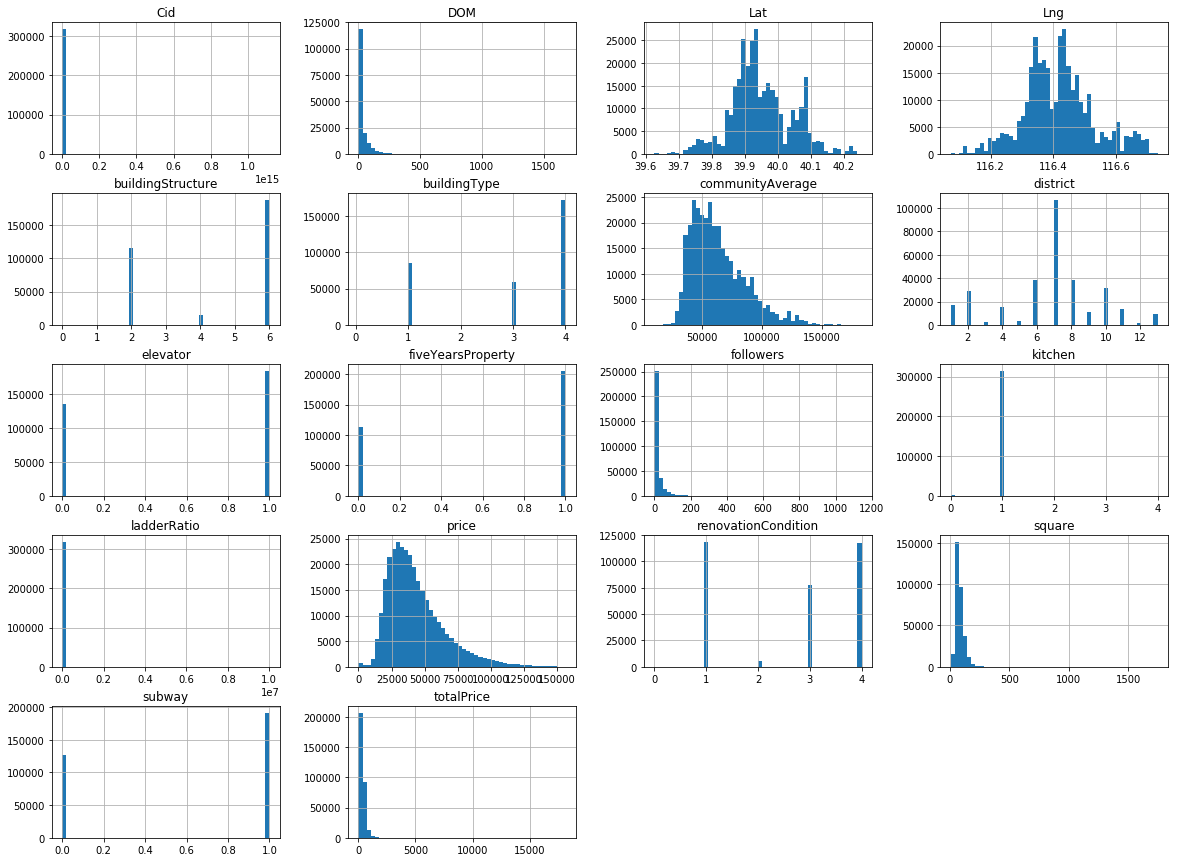

In [5]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

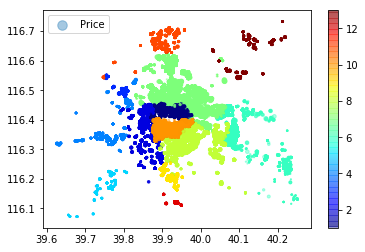

In [6]:
fig = plt.scatter(x=housing['Lat'], y=housing['Lng'], alpha=0.4, \
    s=housing['totalPrice']/100, label='Price', \
    c=housing['district'], cmap=plt.get_cmap('jet'))
plt.colorbar(fig)
plt.legend()
plt.show()

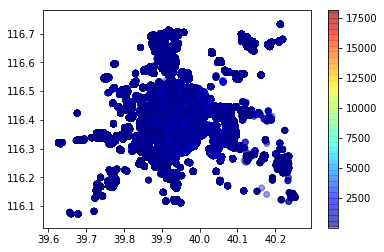

In [7]:
fig = plt.scatter(x=housing['Lat'], y=housing['Lng'], alpha=0.4, \
    c=housing['totalPrice'], cmap=plt.get_cmap('jet'))
plt.colorbar(fig)
plt.show()

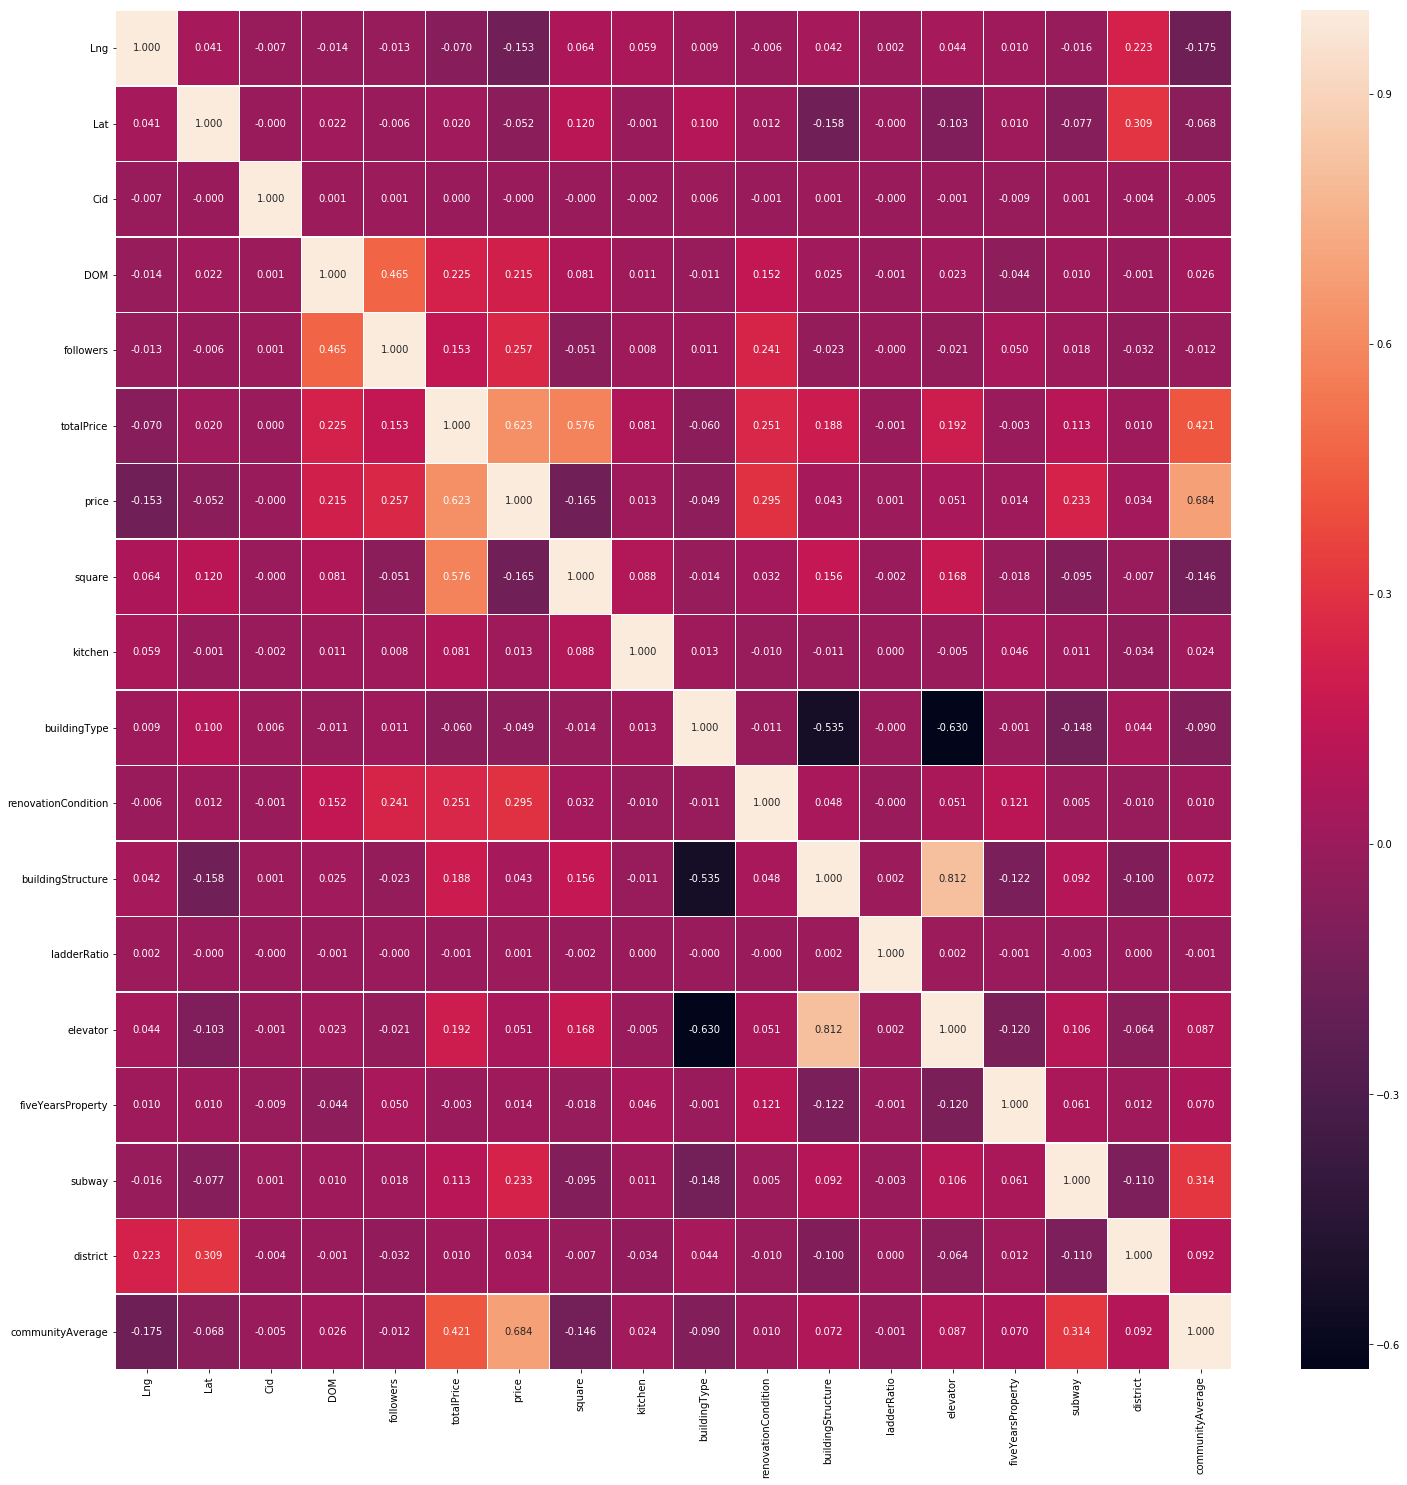

In [8]:
f,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(housing.corr(), annot = True, linewidth = .5, fmt = ".3f",ax = ax)
plt.show()

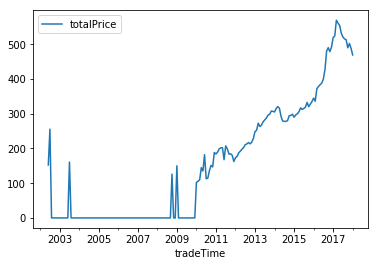

In [9]:
price_by_trade_time = pd.DataFrame()
price_by_trade_time['totalPrice'] = housing['totalPrice']
price_by_trade_time.index = housing['tradeTime'].astype('datetime64[ns]')
price_by_trade_month = price_by_trade_time.resample('M').mean().to_period('M').fillna(0)
price_by_trade_month.plot(kind='line')
plt.show()

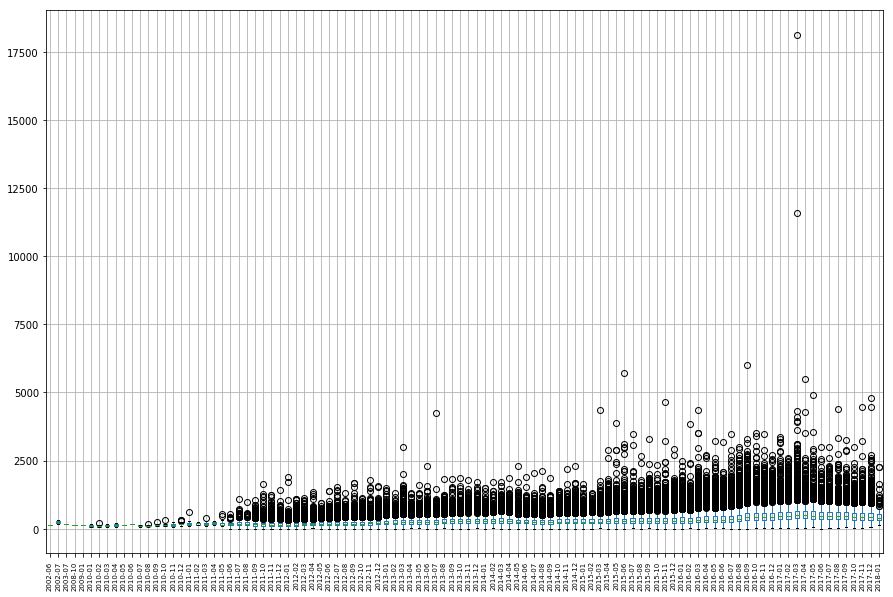

In [10]:
price_stat_trade_month_index = [x.strftime('%Y-%m') for x in set(price_by_trade_time.to_period('M').index)]
price_stat_trade_month_index.sort()
price_stat_trade_month = []
for month in price_stat_trade_month_index:
    price_stat_trade_month.append(price_by_trade_time[month]['totalPrice'].values)
price_stat_trade_month = pd.DataFrame(price_stat_trade_month)
price_stat_trade_month.index = price_stat_trade_month_index
price_stat_trade_month = price_stat_trade_month.T
price_stat_trade_month.boxplot(figsize=(15,10))
plt.xticks(rotation=90,fontsize=7)
plt.show()

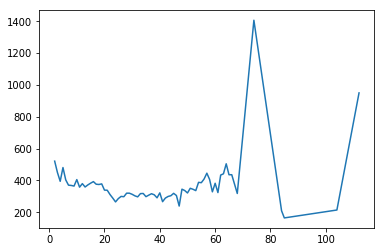

In [11]:
price_by_cons_time = pd.DataFrame()
price_by_cons_time['totalPrice'] = housing['totalPrice']
price_by_cons_time['constructionTime'] = housing['constructionTime']
price_by_cons_time = price_by_cons_time[
	(price_by_cons_time.constructionTime != '0')
	& (price_by_cons_time.constructionTime != '1')
	& (price_by_cons_time.constructionTime != 'Î´Öª')
]
price_by_cons_time['constructionTime'] = price_by_cons_time['constructionTime'].astype('int64')
price_by_cons_time['constructionTime'] = 2018 - price_by_cons_time['constructionTime']
price_by_cons_time_index = list(set(price_by_cons_time['constructionTime']))
price_by_cons_time_index.sort()
price_by_cons_time.index = price_by_cons_time['constructionTime']
price_by_cons_time = price_by_cons_time.drop('constructionTime', axis=1)
price_by_cons_time_line = []
price_by_cons_time_stat = []
for years in price_by_cons_time_index:
	price_by_cons_time_line.append(price_by_cons_time.loc[years]['totalPrice'].mean())
	try:
		price_by_cons_time_stat.append(price_by_cons_time.loc[years]['totalPrice'].values)
	except Exception:
		price_by_cons_time_stat.append(np.array([price_by_cons_time.loc[years]['totalPrice']]))
plt.plot(list(price_by_cons_time_index), price_by_cons_time_line)
plt.show()

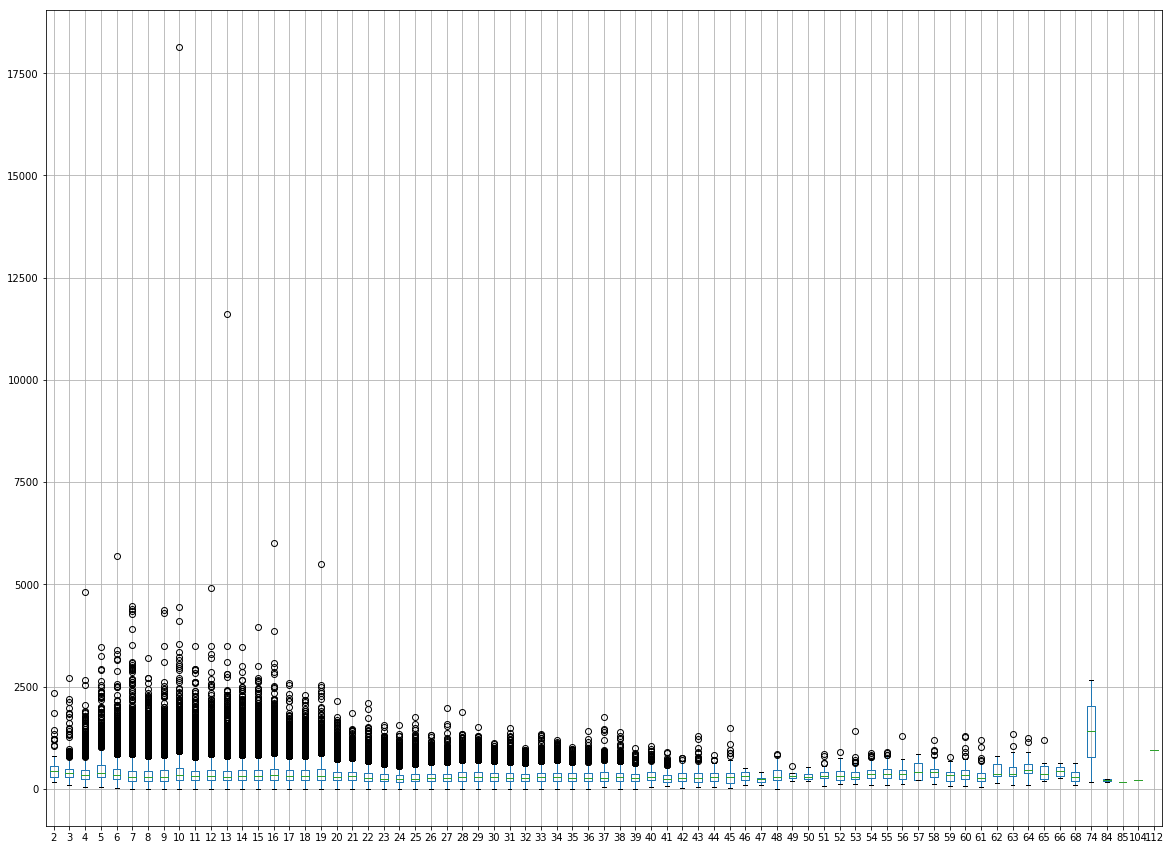

In [12]:
price_by_cons_time_stat = pd.DataFrame(price_by_cons_time_stat)
price_by_cons_time_stat.index = price_by_cons_time_index
price_by_cons_time_stat = price_by_cons_time_stat.T
price_by_cons_time_stat.boxplot(figsize=(20,15))
plt.show()

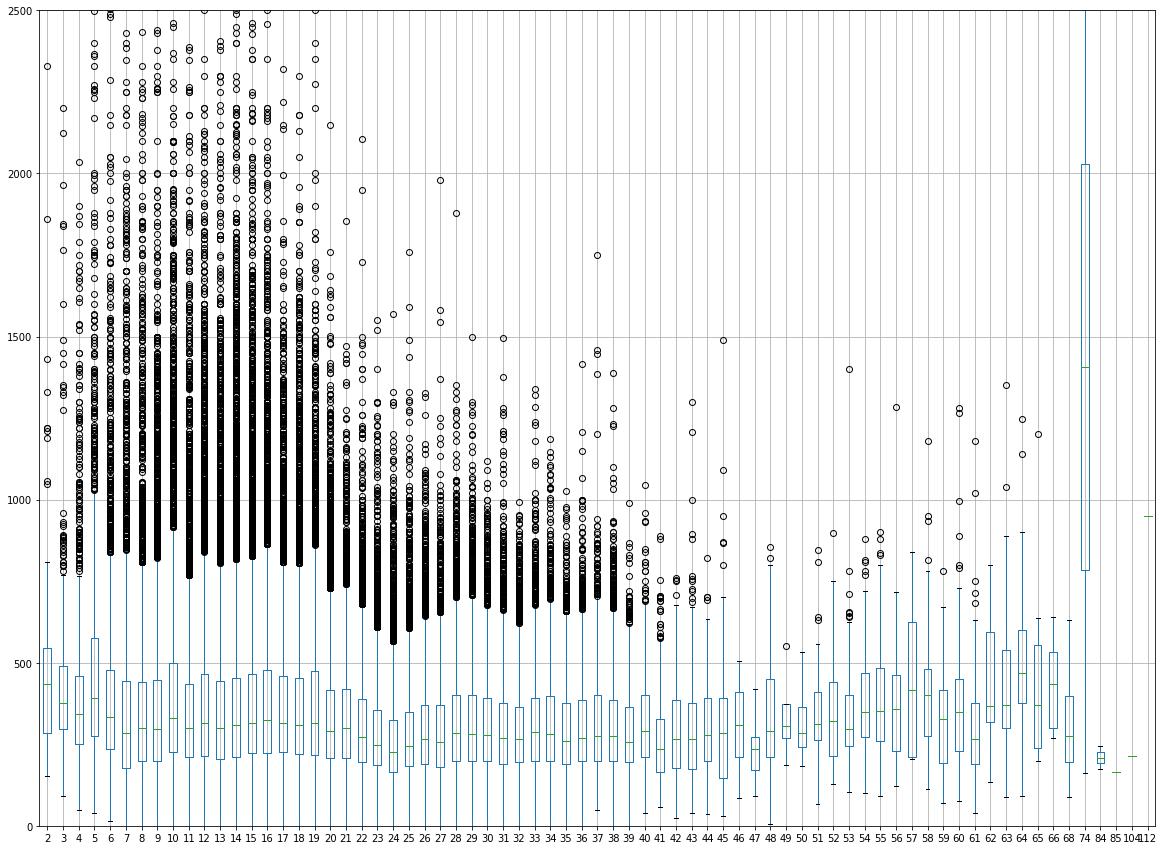

In [13]:
price_by_cons_time_stat.boxplot(figsize=(20,15))
plt.ylim(0,2500)
plt.show()

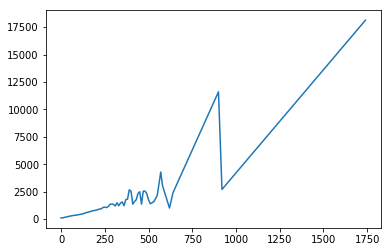

In [14]:
#square and price
price_by_square = pd.DataFrame()
price_by_square['totalPrice'] = housing['totalPrice']
price_by_square['square'] = housing['square']
price_by_square['square'] = np.ceil(price_by_square['square'])
price_by_square['square'] = price_by_square['square'] - (price_by_square['square'] % 10)
price_by_square_index = list(set(price_by_square['square']))
price_by_square_index.sort()
price_by_square.index = price_by_square['square']
price_by_square_line = []
price_by_square_stat = []
for squares in price_by_square_index:
	price_by_square_line.append(price_by_square.loc[squares]['totalPrice'].mean())
	try:
		price_by_square_stat.append(price_by_square.loc[squares]['totalPrice'].values)
	except Exception:
		price_by_square_stat.append(np.array([price_by_square.loc[squares]['totalPrice']]))
plt.plot(price_by_square_index, price_by_square_line)
plt.show()

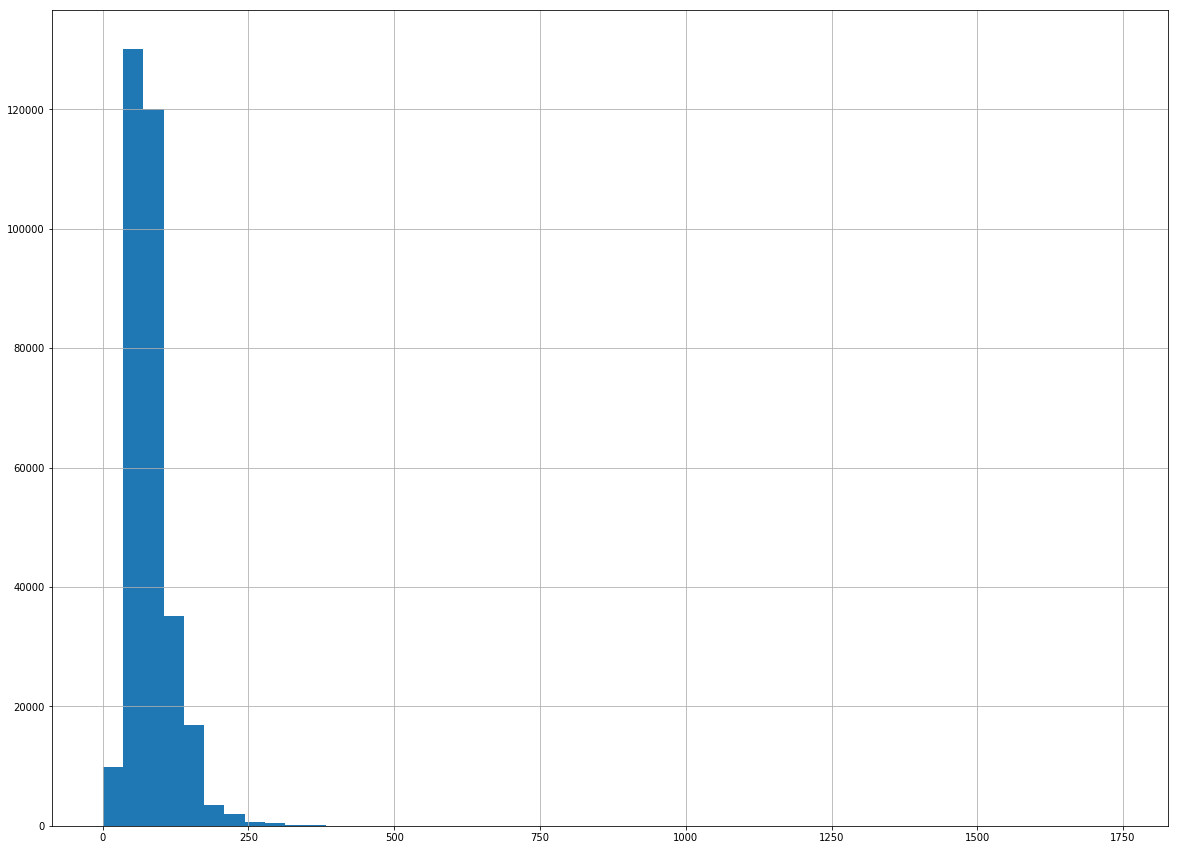

In [15]:
price_by_square['square'].hist(bins=50, figsize=(20,15))
plt.show()

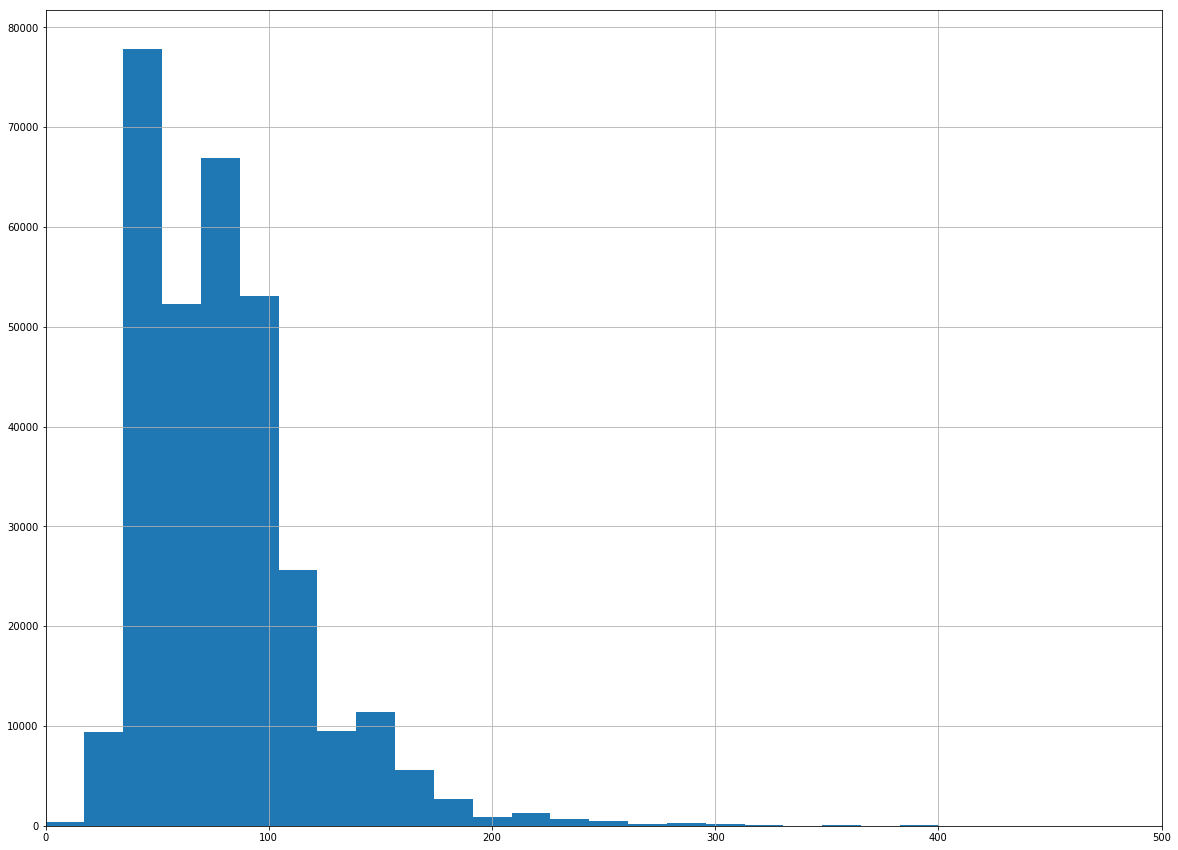

In [16]:
price_by_square['square'].hist(bins=100, figsize=(20,15))
plt.xlim(0,500)
plt.show()

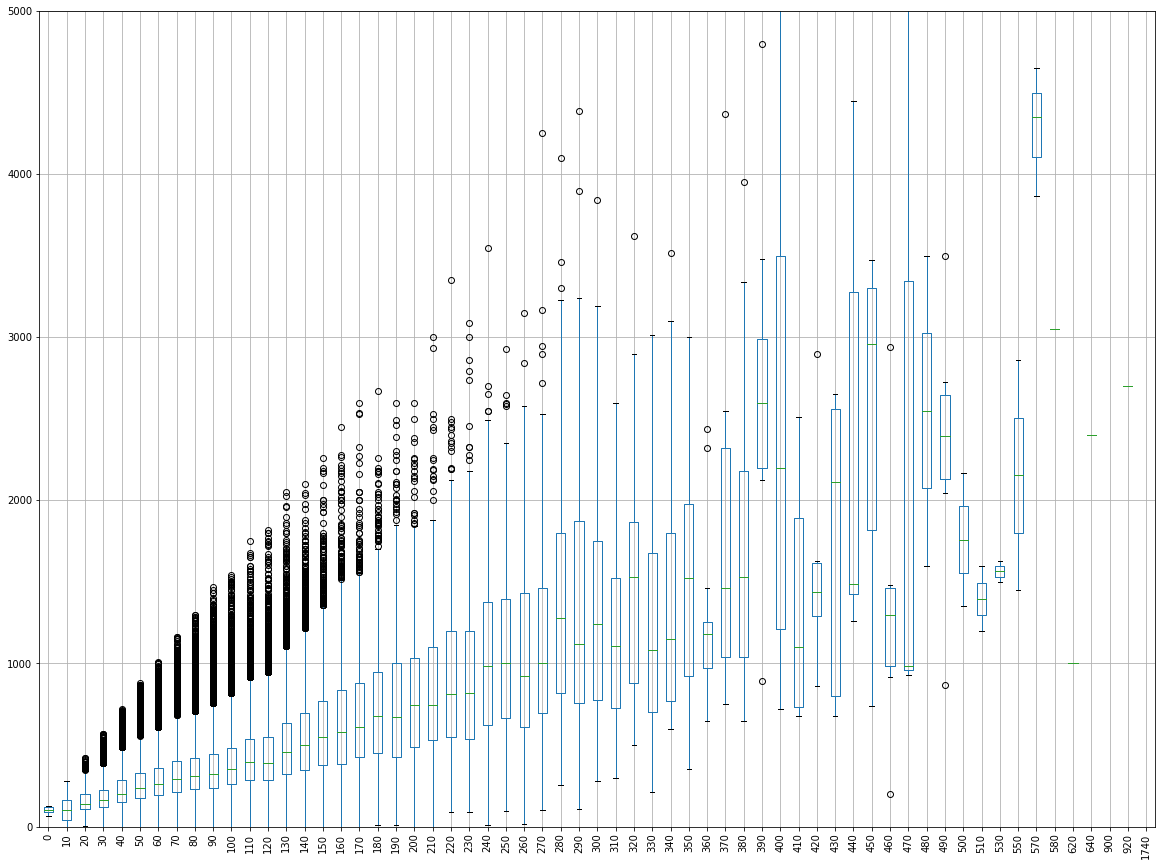

In [17]:
price_by_square_stat = pd.DataFrame(price_by_square_stat).T
price_by_square_index = [int(x) for x in price_by_square_index]
price_by_square_stat.columns = price_by_square_index
price_by_square_stat.boxplot(figsize=(20,15))
plt.xticks(rotation=90)
plt.ylim(0,5000)
plt.show()

In [18]:
def get_mean(price_by_square):
	try:
		price_by_square_index = list(set(price_by_square['square']))
		price_by_square_index.sort()
		price_by_square_line = []
		price_by_square.index = price_by_square['square']
		for squares in price_by_square_index:
			price_by_square_line.append(price_by_square.loc[squares]['totalPrice'].mean())
		price_by_square_index = [int(x) for x in price_by_square_index]
	except Exception:
		price_by_square_line = [price_by_square.loc['totalPrice']]
		price_by_square_index = [int(price_by_square['square'])]
	return price_by_square_line, price_by_square_index

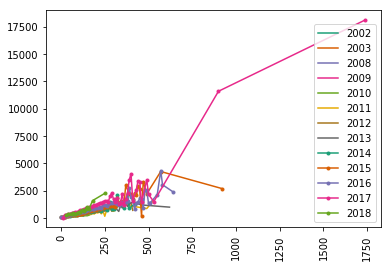

In [19]:
price = pd.DataFrame()
price['totalPrice'] = housing['totalPrice']
price['square'] = housing['square']
price.index = housing['tradeTime'].astype('datetime64[ns]')
price['square'] = np.ceil(price['square'])
price['square'] = price['square'] - (price['square'] % 10)
price = price.to_period('Y')
price_time_index = [x.strftime('%Y') for x in set(price.index)]
price_time_index.sort()
colormap = mpl.cm.Dark2.colors
m_styles = ['','.','o','^','*']
for year, (maker, color) in zip(price_time_index, itertools.product(m_styles, colormap)):
    y, x = get_mean(price.loc[year])
    plt.plot(x, y, color=color, marker=maker, label=year)
plt.xticks(rotation=90)
plt.legend(price_time_index)
plt.show()

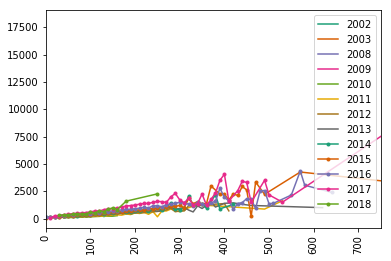

In [20]:
for year, (maker, color) in zip(price_time_index, itertools.product(m_styles, colormap)):
    y, x = get_mean(price.loc[year])
    plt.plot(x, y, color=color, marker=maker, label=year)
plt.xticks(rotation=90)
plt.legend(price_time_index)
plt.xlim(0,750)
plt.show()

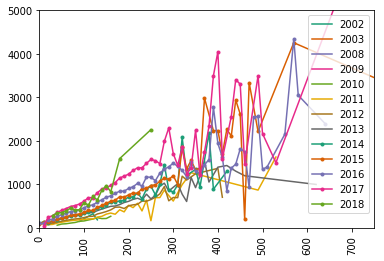

In [21]:
for year, (maker, color) in zip(price_time_index, itertools.product(m_styles, colormap)):
    y, x = get_mean(price.loc[year])
    plt.plot(x, y, color=color, marker=maker, label=year)
plt.xticks(rotation=90)
plt.legend(price_time_index)
plt.xlim(0,750)
plt.ylim(0,5000)
plt.show()

In [22]:
class DataNumCleaner(BaseEstimator, TransformerMixin):
    def __init__(self, clean=True):
        self.clean = clean
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        if self.clean:
            X = X[(X.constructionTime != '0') & (X.constructionTime != '1') & (X.constructionTime != 'Î´Öª')]
            X['constructionTime'] = 2018 - X['constructionTime'].astype('int64')
            X = X[(X.buildingType == 1) | (X.buildingType == 2) | (X.buildingType == 3) | (X.buildingType == 4)]
            X = X[X.livingRoom != '#NAME?']
            X = X[(X.drawingRoom == '0') | (X.drawingRoom == '1') | (X.drawingRoom == '2') | (X.drawingRoom == '3') | (X.drawingRoom == '4') | (X.drawingRoom == '5')]
            X = X[(X.bathRoom == '0') | (X.bathRoom == '1') | (X.bathRoom == '2') | (X.bathRoom == '3') | (X.bathRoom == '4') | (X.bathRoom == '5') | (X.bathRoom == '6') | (X.bathRoom == '7')]
            X.bathRoom = X.bathRoom.astype('float64')
            X.drawingRoom = X.drawingRoom.astype('float64')
            X.livingRoom = X.livingRoom.astype('float64')
            return X
        else:
            return X

In [23]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    """docstring for DataFrameSelector"""
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].values

In [24]:
def display_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Standard deviation: ', scores.std())

In [25]:
housing = load_housing_data('../input/new.csv')
housing = housing.drop(['url','id','price','Cid','DOM','tradeTime', 'floor', 'followers', 'communityAverage'], axis=1)
housing.head()

,Lng,Lat,totalPrice,square,livingRoom,drawingRoom,kitchen,bathRoom,buildingType,constructionTime,renovationCondition,buildingStructure,ladderRatio,elevator,fiveYearsProperty,subway,district
0,116.475489,40.019520,415.0,131.00,2,1,1,1,1.0,2005,3,6,0.217,1.0,0.0,1.0,7
1,116.453917,39.881534,575.0,132.38,2,2,1,2,1.0,2004,4,6,0.667,1.0,1.0,0.0,7
2,116.561978,39.877145,1030.0,198.00,3,2,1,3,4.0,2005,3,6,0.500,1.0,0.0,0.0,7
3,116.438010,40.076114,297.5,134.00,3,1,1,1,1.0,2008,1,6,0.273,1.0,0.0,0.0,6
4,116.428392,39.886229,392.0,81.00,2,1,1,1,4.0,1960,2,2,0.333,0.0,1.0,1.0,1


In [26]:
spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in spliter.split(housing, housing['district']):
    train_set = housing.loc[train_index]
    test_set = housing.loc[test_index]

housing = train_set.copy()

In [27]:
num_attributes = ['Lng', 'Lat', 'square', 'livingRoom', 'drawingRoom', 'kitchen', 'bathRoom', 'constructionTime',  'ladderRatio', 'elevator', 'fiveYearsProperty', 'subway']
cat_attributes = ['buildingType', 'renovationCondition', 'buildingStructure', 'district']

num_pipeline = Pipeline([
    ('cleaner', DataNumCleaner()),
    ('selector', DataFrameSelector(num_attributes)),
    ('imputer', Imputer(strategy='most_frequent')),
    ('std_scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('cleaner', DataNumCleaner()),
    ('selector', DataFrameSelector(cat_attributes)),
    ('encoder', OneHotEncoder())
])

label_pipeline = Pipeline([
    ('cleaner', DataNumCleaner()),
    ('selector', DataFrameSelector(['totalPrice']))
])

full_pipeline = FeatureUnion([
    ('num_pipeline', num_pipeline),
    ('cat_pipeline', cat_pipeline)
])

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [28]:
housing_prepared = full_pipeline.fit_transform(housing)
housing_label = label_pipeline.fit_transform(housing)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determine

In [29]:
lin_svm_reg = LinearSVR()
lin_svm_reg_scores = cross_val_score(lin_svm_reg, housing_prepared, housing_label, scoring='neg_mean_squared_error', cv=10)
lin_svm_reg_rmse_scores = np.sqrt(-lin_svm_reg_scores)
display_scores(lin_svm_reg_rmse_scores)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

Scores:  [152.00566633 151.48775192 152.23247901 150.9771931  153.7145824
 150.25433913 149.85159163 150.18786305 150.63527151 155.33421688]
Mean:  151.66809549644321
Standard deviation:  1.6470310949225409


In [30]:
lin_svm_reg = LinearSVR(C=0.5,loss='squared_epsilon_insensitive')
lin_svm_reg.fit(housing_prepared,housing_label)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVR(C=0.5, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='squared_epsilon_insensitive',
     max_iter=1000, random_state=None, tol=0.0001, verbose=0)

In [31]:
X_test_prepared = full_pipeline.fit_transform(test_set)
y_test = label_pipeline.fit_transform(test_set)
final_predictons = lin_svm_reg.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictons)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determine

In [32]:
final_rmse = np.sqrt(final_mse)
print(final_rmse)

144.75553313583714


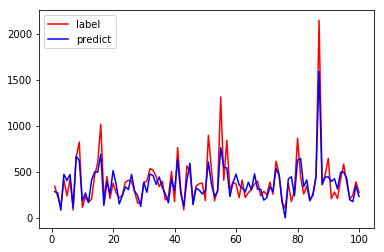

In [33]:
test_index = [randint(0,len(y_test)) for i in range(100)]
y_label = [y_test[index] for index in test_index]
y_predict = [lin_svm_reg.predict(X_test_prepared[index]) for index in test_index]
x = [i+1 for i in range(100)]
plt.plot(x, y_label, c='red', label='label')
plt.plot(x, y_predict, c='blue', label='predict')
plt.legend()
plt.show()

In [34]:
joblib.dump(lin_svm_reg,'BeijingHousingPricePredicter.pkl')

['BeijingHousingPricePredicter.pkl']